# Image Retrieval

In [1]:
#!pip install mahotas

In [2]:
import cv2
import numpy as np
import os
import glob
import mahotas as mt

import matplotlib.pyplot as plt

from os import listdir # to list files in a folder
import imageio
from imageio import imread
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Parallel, delayed # to execute function in parallel
from skimage import feature

# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

# Importing Silhouette Score implementation from scikit-learn
from sklearn.metrics import silhouette_score

import re

#from github.MainClass import Github

---
## Images without Background

---
### Step 1 - get images and patches

In [3]:
# We have to define:
# the size of the patch and number of patches per image
# the path to search for training images
# note each patch has an extra dimension due to the color channels (1 for graylevel, 3 for RGB) 


def get_patches(img_file, random_state, patch_size=(11, 11), n_patches=250):
    '''
    Extracts subimages
    
    Parameters:
        img_file: path for an image
        patch_size: size of each patch
        n_patches: number of patches to be extracted
        
    Returns:
        images patches
    '''

    img = imread(img_file)
    
    # Extract subimages
    patch = extract_patches_2d(img, 
                               patch_size=patch_size,
                               max_patches=n_patches, 
                               random_state=random_state)
    
    return patch.reshape((n_patches, 
                          np.prod(patch_size) * len(img.shape)))

In [4]:
path = './waste_images/train_segmented/'

In [5]:
listdir(path)

['Aluminium',
 'Battery',
 'Cable and Wire',
 'Cardboard and Paper',
 'Connector',
 'Copper',
 'Iron',
 'Magnetic Tape',
 'Printed Circuit Board',
 'Printer Ribbon and Toner',
 'Tube and Screen',
 'Water Pump']

In [6]:
imgs_path = []

for folder in listdir(path):
    for filename in listdir(path+folder):
        imgs_path.append(path+folder+'/'+filename)
imgs_path

['./waste_images/train_segmented/Aluminium/Aluminium18_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium1_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium21_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium26_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium30_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium31_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium32_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium37_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium3_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium40_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium44_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium45_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium46_segmented.JPG',
 './waste_images/train_segmented/Aluminium/Aluminium47_segmented.JPG',
 './wast

Patches extracted to create dictionary of features
Total of images =  565
Size of each array of patches =  (250, 675)


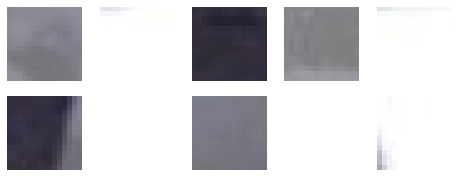

In [7]:
# BOF parameters
tam_patch = (15, 15)
n_patches = 250
#path_imgs = './waste_images/all/'
random_state = 1

# Total of images
n_imgs = len(imgs_path)

# Extract patches in parallel
# returns a list of the same size of the number of images
patch_arr = Parallel(n_jobs=-1)(delayed(get_patches)(arq_img, 
                                                    random_state,
                                                    tam_patch,
                                                    n_patches)
                                for arq_img in imgs_path)

print('Patches extracted to create dictionary of features')
print('Total of images = ', len(patch_arr))
print('Size of each array of patches = ', patch_arr[0].shape)

# Show some image patches
img_ind = 32
plt.figure(figsize=(8,3))
for i in np.arange(1,11):
    plt.subplot(2,5,i)
    plt.imshow(patch_arr[img_ind][i].reshape((tam_patch[0],tam_patch[1],3)))
    plt.axis('off')

In [8]:
patch_arr[0].shape

(250, 675)

---
### Step 2 - obtain features from patches

We are going to use GLCM and LBP features as base descriptors

In [9]:
def glcm_features(img, sampling_pixels=8):
    
    # Converting to grayscale
    if (len(img.shape) > 2):
        img = img.astype(float)
        # RGB to grayscale convertion using Luminance
        img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

    # Converting to uint8 type for 256 graylevels
    img = img.astype(np.uint8)

    
    '''
    # Normalize values can also help improving description
    i_min = np.min(img)
    i_max = np.max(img)
    if (i_max - i_min != 0):
        img = (img - i_min)/(i_max-i_min)
    '''
        
    # Calculate haralick texture features for 4 types of adjacency
    textures = mt.features.haralick(img)

    # Computing the histogram of features
    (hist, _) = np.histogram(textures.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))
    
    # Normalization
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    # Return the histogram of features
    return hist

In [10]:
def lbp_features(img, radius=1, sampling_pixels=8):
    
    # LBP operates in single channel images so if RGB images are provided
    # we have to convert it to grayscale
    if (len(img.shape) > 2):
        img = img.astype(float)
        # RGB to grayscale convertion using Luminance
        img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

    # Converting to uint8 type for 256 graylevels
    img = img.astype(np.uint8)
        
    # Normalize values can also help improving description
    i_min = np.min(img)
    i_max = np.max(img)
    if (i_max - i_min != 0):
        img = (img - i_min)/(i_max-i_min)
        
    # Compute LBP
    lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")
    
    # LBP returns a matrix with the codes, so we compute the histogram
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

    # Normalization
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    # Return the histogram of Local Binary Patterns
    return hist

In [11]:
patch_arr = np.array(patch_arr, copy=True)
patch_arr = patch_arr.reshape((patch_arr.shape[0] * patch_arr.shape[1],
                               tam_patch[0],tam_patch[0],3))

# Obtaining features lbp for each patch
patch_glcm = []
patch_lbp = []

for pat in patch_arr:
    
    lbp = lbp_features(pat,2,8)
    patch_lbp.append(lbp)
    
    glcm = glcm_features(pat,8)
    patch_glcm.append(glcm)

In [12]:
patch_lbp = np.array(patch_lbp, copy=False)
print('Instances = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])
print('Created LBP feature spaces')
print('\tpatches = ', len(patch_lbp), ' size = ', patch_lbp[0].shape[0])

Instances =  141250  size =  10
Created LBP feature spaces
	patches =  141250  size =  10


In [13]:
patch_glcm = np.array(patch_glcm, copy=False)
print('Instances = ', len(patch_glcm), ' size = ', patch_glcm[0].shape[0])
print('Created GLCM feature spaces')
print('\tpatches = ', len(patch_glcm), ' size = ', patch_glcm[0].shape[0])

Instances =  141250  size =  10
Created GLCM feature spaces
	patches =  141250  size =  10


In [14]:
patch_lbp.shape, patch_glcm.shape

((141250, 10), (141250, 10))

---
### Step 3 - learn dictionary

We are going to use a clustering algorithm, KMeans, defining the number of visual words
* can range from 25 to 1000    

In [15]:
# GLCM

np.random.seed(1658)
sample_idx = np.random.choice(patch_glcm.shape[0], size = int(patch_glcm.shape[0]*0.1), replace = False)
descriptors_sample = patch_glcm[sample_idx]
print(descriptors_sample.shape)

# Recommendation is to explore between 25 and 1,000 clusters
n_clusters_glcm = np.arange(25, 1000, 50)
scores_glcm=[]
dict_scores_glcm = {}

for k in n_clusters_glcm:
    voc_sample, _ = kmeans(descriptors_sample, k, 1) 
    clusters, _ = vq(descriptors_sample, voc_sample)
    score = silhouette_score(descriptors_sample, clusters)
    scores_glcm.append(score)
    dict_scores_glcm[k] = score

(14125, 10)


In [16]:
#dict_scores_glcm

In [17]:
# LBP

np.random.seed(1658)
sample_idx = np.random.choice(patch_lbp.shape[0], size = int(patch_lbp.shape[0]*0.1), replace = False)
descriptors_sample = patch_lbp[sample_idx]
print(descriptors_sample.shape)

# Recommendation is to explore between 25 and 1,000 clusters
n_clusters_lbp = np.arange(25, 1000, 50)
scores_lbp=[]
dict_scores_lbp = {}

for k in n_clusters_lbp:
    voc_sample, _ = kmeans(descriptors_sample, k, 1) 
    clusters, _ = vq(descriptors_sample, voc_sample)
    score = silhouette_score(descriptors_sample, clusters)
    scores_lbp.append(score)
    dict_scores_lbp[k] = score

(14125, 10)


In [18]:
scores_list = [scores_glcm, scores_lbp]
#scores_list

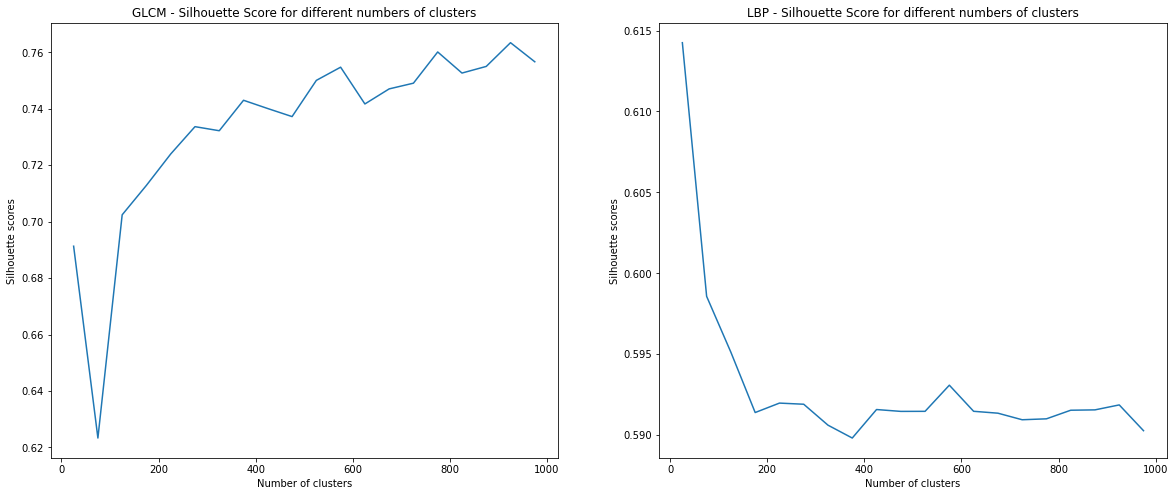

In [19]:
fig, (axs) = plt.subplots(1, 2, figsize=(20, 8))

for scores, i in zip(scores_list, range(len(scores_list))):
    
    if i == 0:
        title = 'GLCM'
        axs[i].plot(n_clusters_glcm, scores)
        axs[i].set_title(title + " - Silhouette Score for different numbers of clusters")
        axs[i].set_xlabel('Number of clusters')
        axs[i].set_ylabel('Silhouette scores')
        
    elif i == 1:
        title = 'LBP'
        axs[i].plot(n_clusters_lbp, scores)
        axs[i].set_title(title + " - Silhouette Score for different numbers of clusters")
        axs[i].set_xlabel('Number of clusters')
        axs[i].set_ylabel('Silhouette scores')

In [20]:
max_key_glcm = max(dict_scores_glcm, key=dict_scores_glcm.get)
max_key_lbp = max(dict_scores_lbp, key=dict_scores_lbp.get)

print('Number of clusters for GLCM: ', max_key_glcm)
print('Number of clusters for LBP: ', max_key_lbp)

Number of clusters for GLCM:  925
Number of clusters for LBP:  25


In [21]:
# k-means model for GLCM
n_dic_glcm = max_key_glcm # size of the dictionary
random_state = 1

# Define a KMeans clustering model
kmeans_model_glcm = KMeans(n_clusters=n_dic_glcm, 
                      verbose=False, 
                      init='random',
                      random_state=random_state, 
                      n_init=3)

kmeans_model_glcm.fit(patch_glcm)

KMeans(init='random', n_clusters=925, n_init=3, random_state=1, verbose=False)

In [22]:
# k-means model for LBP
n_dic_lbp = max_key_lbp # size of the dictionary
random_state = 1

# Define a KMeans clustering model
kmeans_model_lbp = KMeans(n_clusters=n_dic_lbp, 
                      verbose=False, 
                      init='random',
                      random_state=random_state, 
                      n_init=3)
# Fit the model
kmeans_model_lbp.fit(patch_lbp)

KMeans(init='random', n_clusters=25, n_init=3, random_state=1, verbose=False)

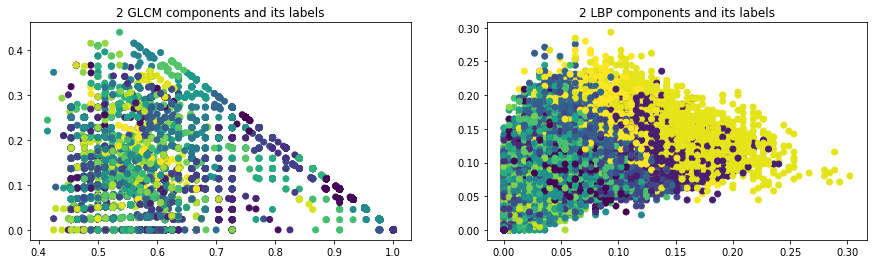

In [23]:
fig, (axs) = plt.subplots(1, 2, figsize=(15, 4))

for scores, i in zip(scores_list, range(len(scores_list))):
    
    if i == 0:
        title = 'GLCM'
        axs[i].scatter(patch_glcm[:, 0], patch_glcm[:, 1], c=kmeans_model_glcm.labels_)
        axs[i].set_title("2 " + title + " components and its labels")
                       
    elif i == 1:
        title = 'LBP'
        axs[i].scatter(patch_lbp[:, 0], patch_lbp[:, 1], c=kmeans_model_lbp.labels_)
        axs[i].set_title("2 " + title + " components and its labels")

---
### Step 4 - obtain histograms from Bag of Features

Since we have `n_imgs` with `n_patches`

We check the frequency of each visual word in each training images

In [24]:
# GLCM

# Compute features for each image
img_feats_glcm = []

for i in range(n_imgs):
    
    # Predicting n_patches of an image
    y = kmeans_model_glcm.predict(patch_glcm[i*n_patches: (i*n_patches)+n_patches])

    # Computes histogram and append in the array
    hist_bof,_ = np.histogram(y, bins=range(n_dic_glcm+1), density=True)
    img_feats_glcm.append(hist_bof)

img_feats_glcm = np.array(img_feats_glcm, copy=False)
print('Number of images and features = ', img_feats_glcm.shape)

Number of images and features =  (565, 925)


In [25]:
# LBP

# Compute features for each image
img_feats_lbp = []

for i in range(n_imgs):
    
    # Predicting n_patches of an image
    y = kmeans_model_lbp.predict(patch_lbp[i*n_patches: (i*n_patches)+n_patches])

    # Computes histogram and append in the array
    hist_bof,_ = np.histogram(y, bins=range(n_dic_lbp+1), density=True)
    img_feats_lbp.append(hist_bof)

img_feats_lbp = np.array(img_feats_lbp, copy=False)
print('Number of images and features = ', img_feats_lbp.shape)

Number of images and features =  (565, 25)


Array `img_feats` is a set of features for each image

---
### Step 5 - using features for recognition

Let us use the features for *content-based image retrieval*

In [26]:
def retrieve_images(path_query, feature_extractor, img_feats, kmeans_model, n_dic):
    
    # Get query patches
    query_patches = get_patches(path_query, random_state, tam_patch, n_patches)
    query_patches = np.array(query_patches, copy=False)

    query_patches = query_patches.reshape((query_patches.shape[0],
                               tam_patch[0],tam_patch[0],3))

    #print('Extracted patches')
    #print(query_patches.shape)
    
    img_feats = img_feats.copy()
    
    # Get GLCM and LBP features for extracted patches from query image
    query = []
    
    if feature_extractor == 'glcm':
        for pat in query_patches:
            glcm = glcm_features(pat,8)
            query.append(glcm)
        
        suptitle = 'GLCM'
    
    elif feature_extractor == 'lbp':
        for pat in query_patches:
            lbp = lbp_features(pat,2,8)
            query.append(lbp)
        
        suptitle = 'LBP'
            
    query = np.array(query, copy=False)
    
    # Get visual words for query and computes descriptor
    y = kmeans_model.predict(query)
    query_feats,_ = np.histogram(y, bins=range(n_dic+1), density=True)
  

    # Computes distance
    dists = []
    for i in range(n_imgs):
        diq = np.sqrt(np.sum((img_feats[i]-query_feats)**2))
        dists.append(diq)
    
    # Check the nearest images
    k = 8
    k_cbir = np.argsort(dists)[:k]
    k_cbir = np.argsort(dists)[:k]

    imgq = imageio.imread(path_query)
            
        
    # Show image retrieval based on query

    plt.figure(figsize=(12,8))
    plt.subplot(331); plt.imshow(imgq)
    plt.title('Query'); plt.axis('off')

    imgs = []
    for i in range(k):
        imgs.append(imageio.imread(imgs_path[k_cbir[i]]))
        filename = imgs_path[k_cbir[i]]
        filename = filename[filename.rfind("/"):]
        filename = re.search('/(.*)_', filename).group(1)
        filename = re.findall('([a-zA-Z ]*)\d*.*',filename)[0]
  
        plt.subplot(3,3,i+2); plt.imshow(imgs[i])
        plt.suptitle(suptitle)
        plt.title('%d, %.4f, %s' % (i, dists[k_cbir[i]], filename))
        plt.axis('off')

#### Aluminium

In [101]:
path_query = './waste_images/test_segmented/Aluminium/Aluminium63_segmented.JPG'
imgq = imageio.imread(path_query)

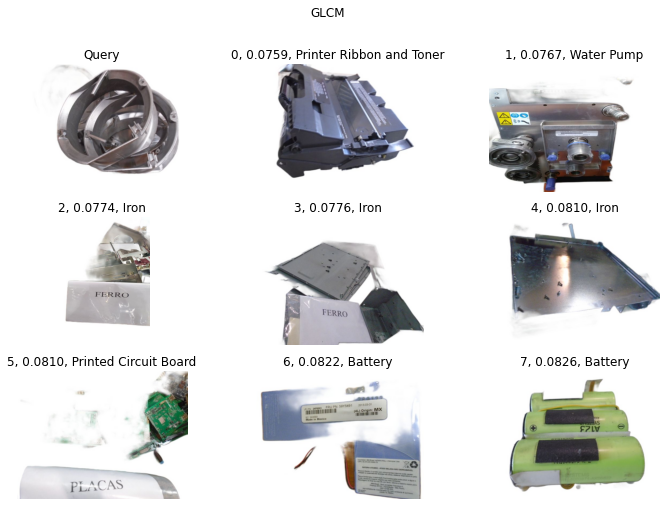

In [102]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

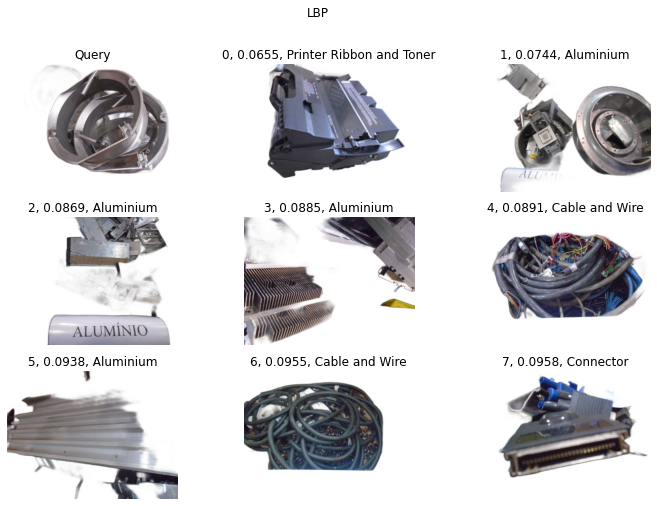

In [103]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)

#### Battery

In [105]:
path_query = './waste_images/test_segmented/Battery/Battery53_segmented.JPG'
imgq = imageio.imread(path_query)

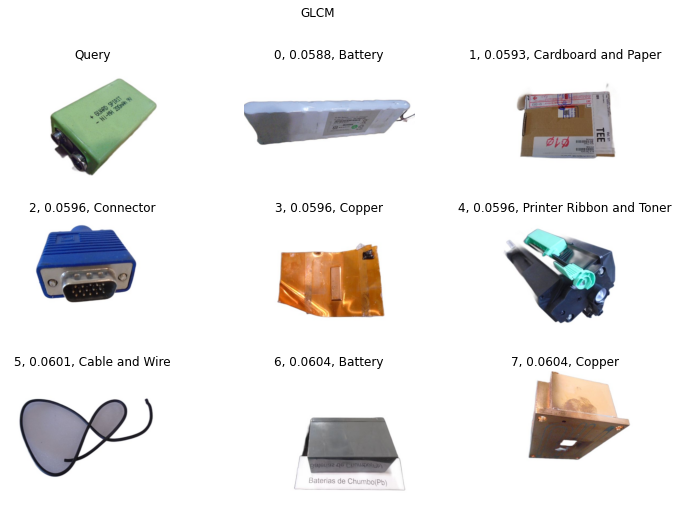

In [106]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

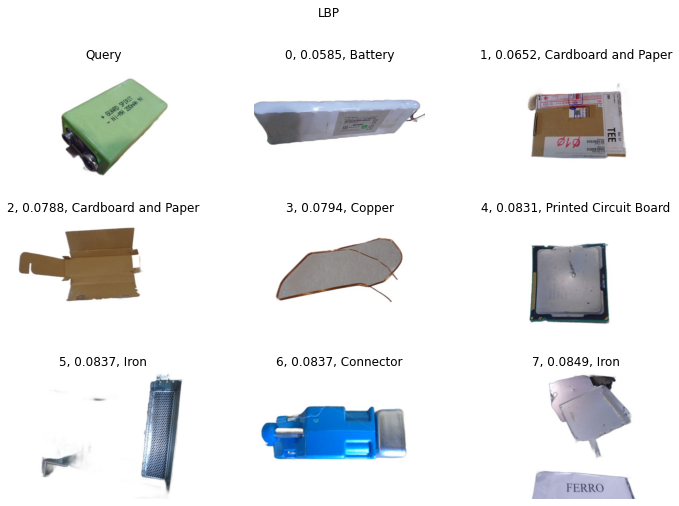

In [107]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)

#### Cable and Wire 

In [108]:
path_query = './waste_images/test_segmented/Cable and Wire/Cable and Wire7_segmented.JPG'
imgq = imageio.imread(path_query)

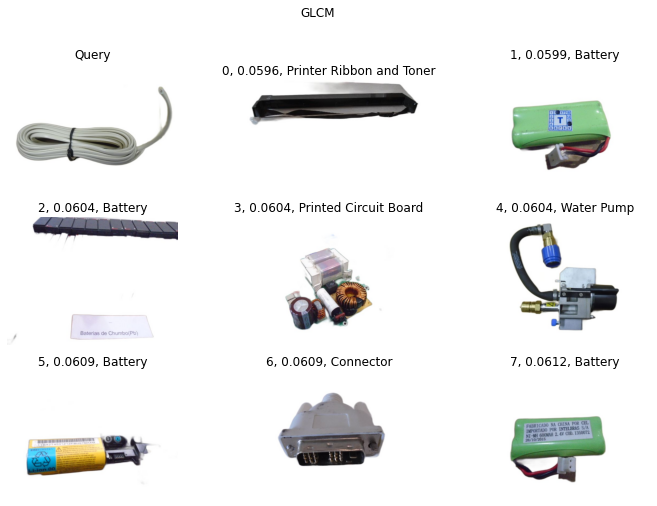

In [109]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

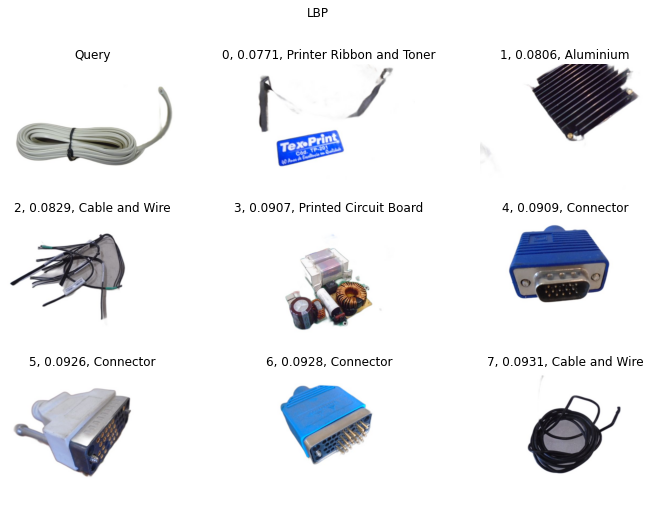

In [110]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)

#### Carboard and Paper 

In [111]:
path_query = './waste_images/test_segmented/Cardboard and Paper/Cardboard and Paper2_segmented.JPG'
imgq = imageio.imread(path_query)

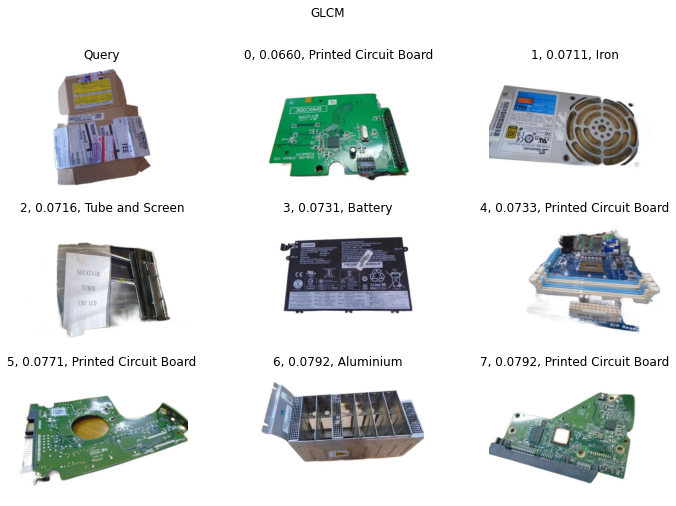

In [112]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

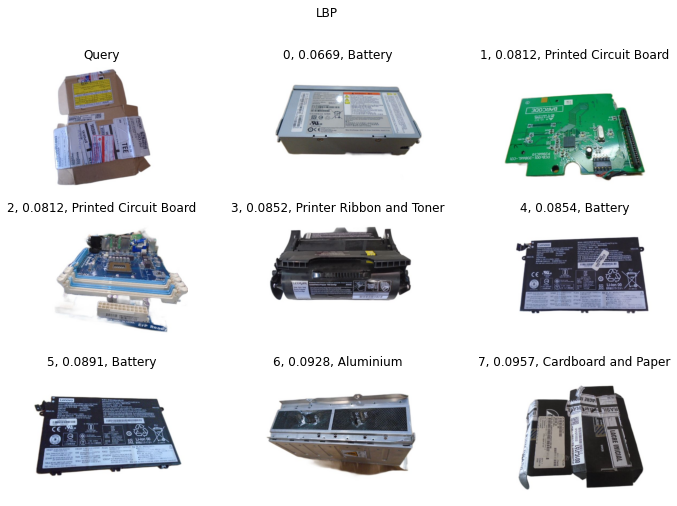

In [113]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)

#### Connector

In [115]:
path_query = './waste_images/test_segmented/Connector/Connector38_segmented.JPG'
imgq = imageio.imread(path_query)

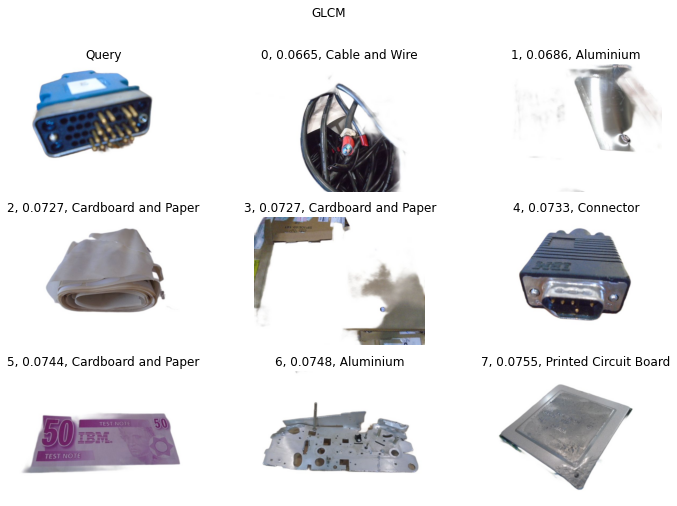

In [116]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

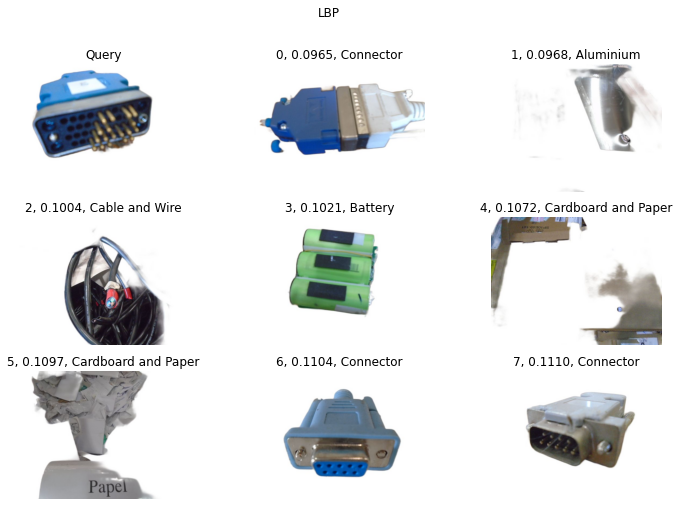

In [117]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)

#### Copper 

In [121]:
path_query = './waste_images/test_segmented/Copper/Copper5_segmented.JPG'
imgq = imageio.imread(path_query)

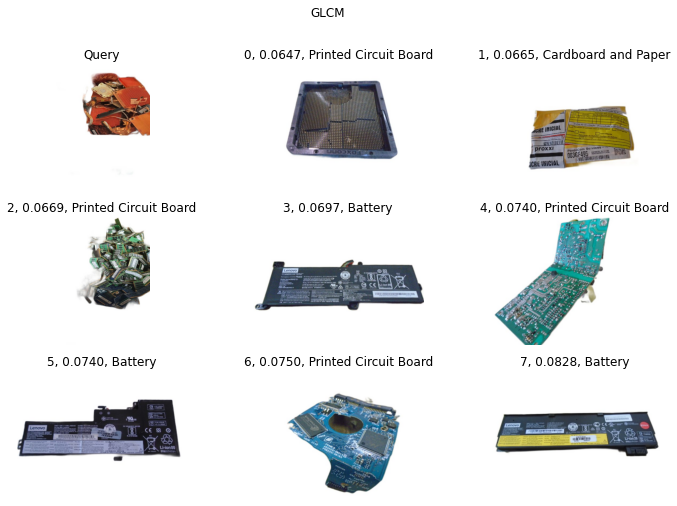

In [122]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

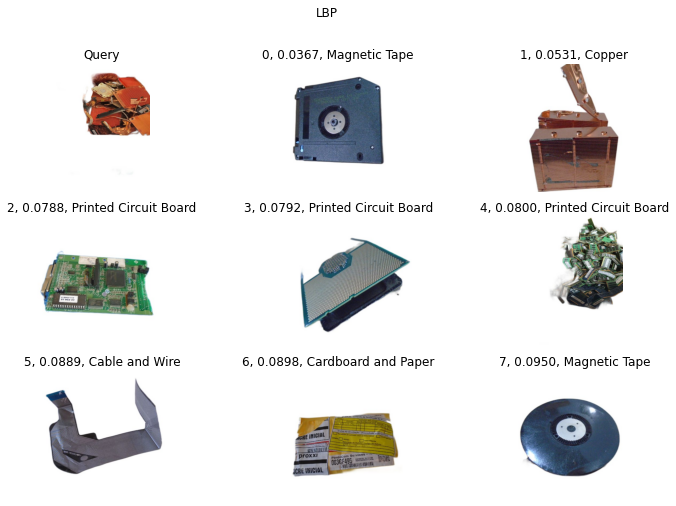

In [123]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)

#### Iron 

In [124]:
path_query = './waste_images/test_segmented/Iron/Iron3_segmented.JPG'
imgq = imageio.imread(path_query)

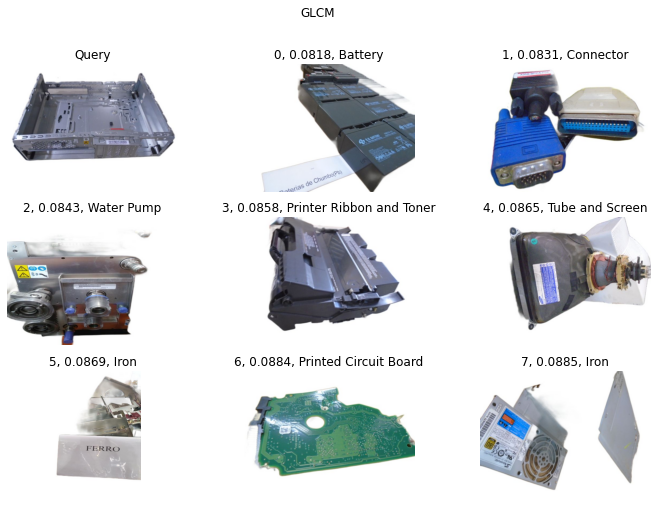

In [125]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

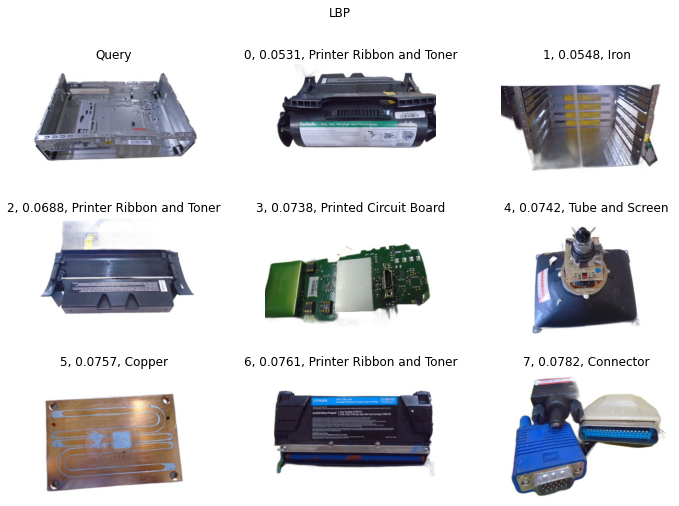

In [126]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)

#### Magnetic Tape 

In [128]:
path_query = './waste_images/test_segmented/Magnetic Tape/Magnetic Tape5_segmented.JPG'
imgq = imageio.imread(path_query)

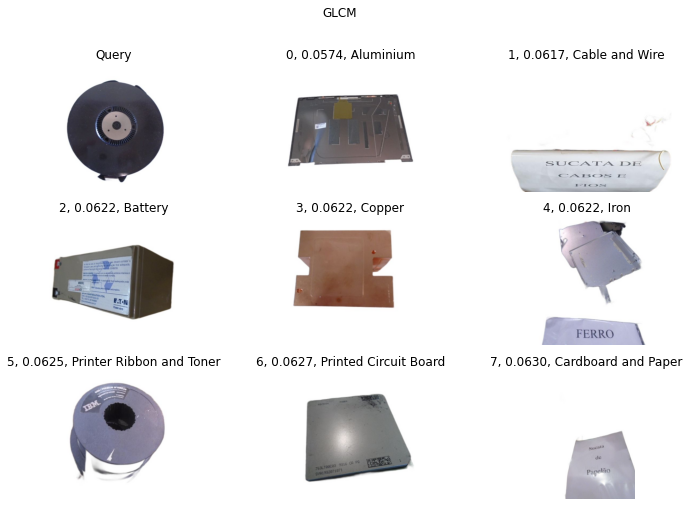

In [129]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

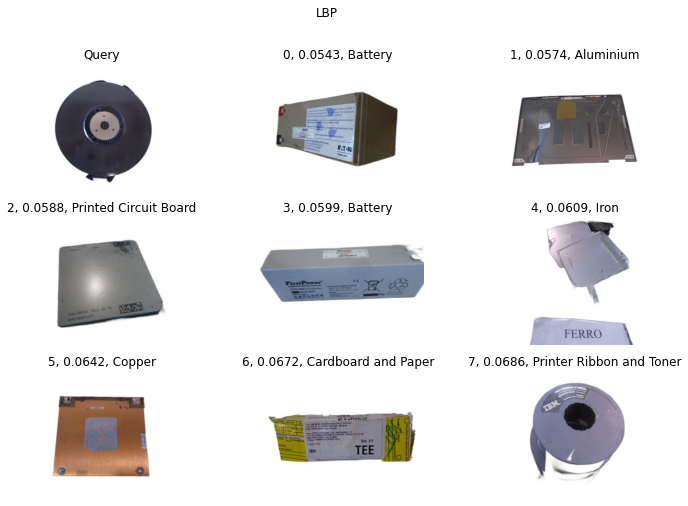

In [130]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)

#### Printed Circuit Board 

In [131]:
path_query = './waste_images/test_segmented/Printed Circuit Board/Printed Circuit Board149_segmented.JPG'
imgq = imageio.imread(path_query)

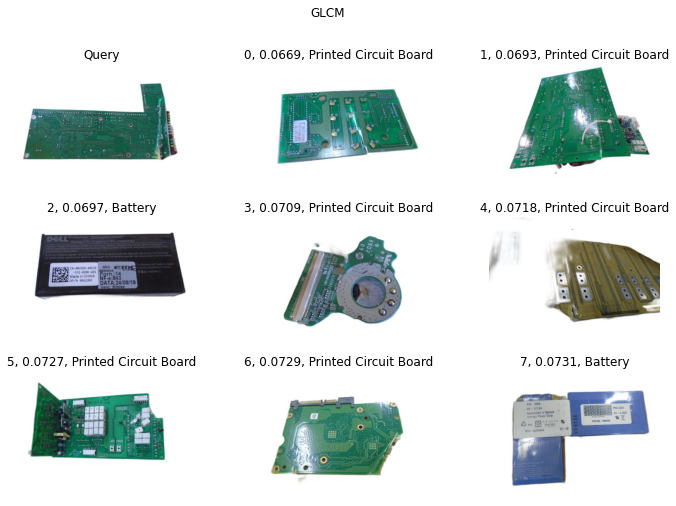

In [132]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

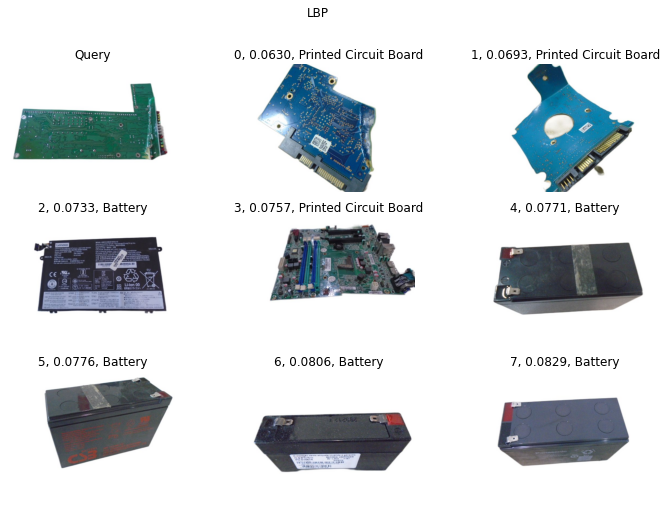

In [133]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)

#### Printer Ribbon and Toner

In [134]:
path_query = './waste_images/test_segmented/Printer Ribbon and Toner/Printer Ribbon and Toner11_segmented.JPG'
imgq = imageio.imread(path_query)

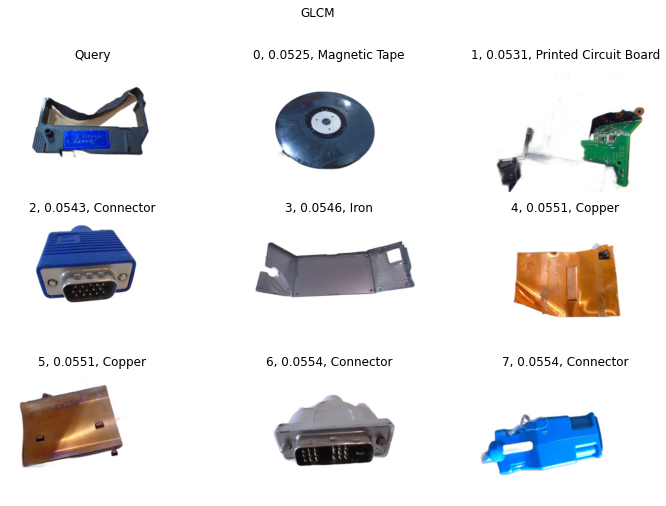

In [135]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

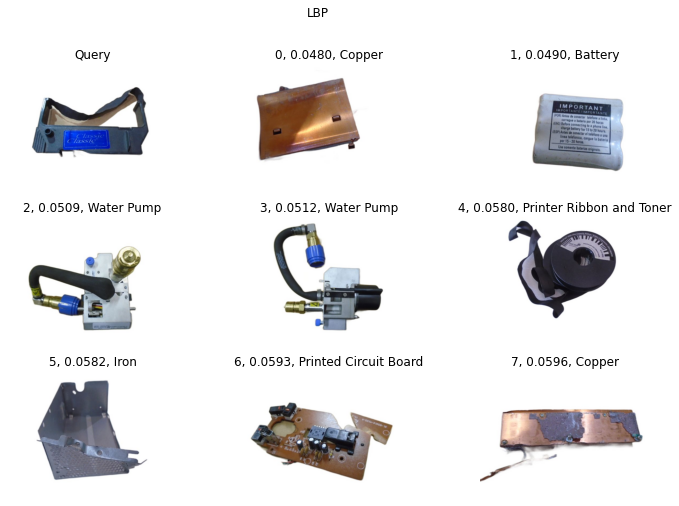

In [136]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)

#### Tube and Screen 

In [137]:
path_query = './waste_images/test_segmented/Tube and Screen/Tube and Screen28_segmented.JPG'
imgq = imageio.imread(path_query)

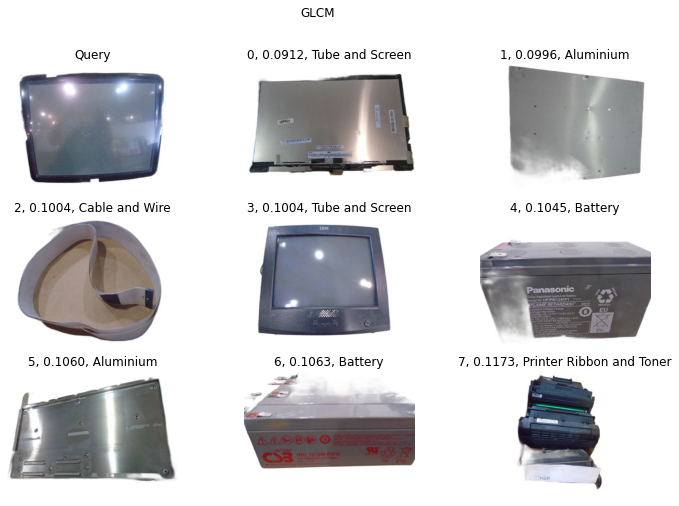

In [138]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

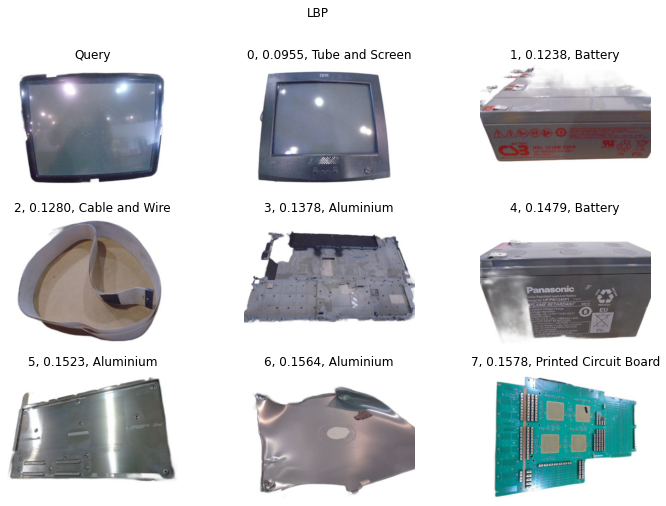

In [139]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)

#### Water Pump 

In [140]:
path_query = './waste_images/test_segmented/Water Pump/Water Pump5_segmented.JPG'
imgq = imageio.imread(path_query)

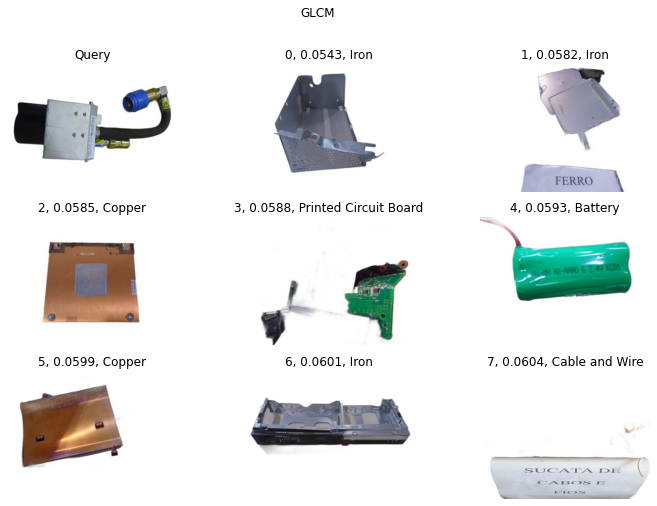

In [141]:
# GLCM
retrieve_images(path_query, 'glcm', img_feats_glcm, kmeans_model_glcm, n_dic_glcm)

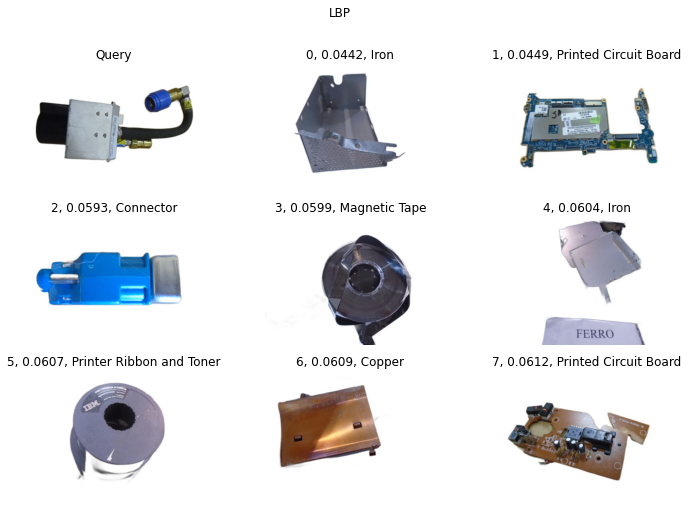

In [142]:
# LBP
retrieve_images(path_query, 'lbp', img_feats_lbp, kmeans_model_lbp, n_dic_lbp)